In [1]:
import pandas as pd

pd.options.mode.copy_on_write = True

In [2]:
df = pd.read_csv('files/csv/land_cmh_raw.csv', header=None)
df.columns = ['PriceTitle', 'Location', 'Size', 'Agent', 'Link', 'Desc']
df = df.drop_duplicates(subset=['PriceTitle', 'Location', 'Size', 'Link'])
df.describe()

,PriceTitle,Location,Size,Agent,Link,Desc
count,1237,1237,1230,492,1237,1237
unique,335,4,329,88,1237,1130
top,Rp 4 Juta /m²,"Cimahi Utara, Cimahi",122 m²,ERA Inno logo,/properti/cimahi/las4028030/?itm_source=organi...,"Tanah di Cipageran, Kec. Cimahi Utara, Cimahi ..."
freq,85,860,111,43,1,15


In [3]:
def to_numeric_term(s: str):
    s = str(s).lower()
    if s == 'miliar': return 1e9
    if s == 'juta': return 1e6
    if s == 'ribu': return 1e3

def assign_price_per_m2(df_inp: pd.DataFrame):
    # separate per meter2 price and total price
    str_m2 = 'Rp (.*?) /m²'
    str_total = 'Rp (.*?) Total'
    df = df_inp['PriceTitle'].str.extract(f'{str_m2}|{str_total}')
    df.columns = ['price_per_m2_raw', 'price_total_raw']
    df = df.assign(total_size=df_inp['Size'], price_per_m2=[0.0 for _ in range(len(df))])

    # convert per meter2 price to numeric
    pm2 = df['price_per_m2_raw']
    pm2_f : pd.Series = pm2[pm2.notnull()]
    pm2_f = pm2_f.str.extract('(.*?) ([a-zA-Z]*)')
    pm2_f.columns = ["pt1", "pt2"]
    pm2_f["pt1"] = pm2_f["pt1"].str.replace(',','.').astype(float)
    pm2_f["pt2"] = pm2_f["pt2"].apply(to_numeric_term)
    pm2_f = pm2_f["pt1"] * pm2_f["pt2"]
    df.loc[pm2.notnull(), 'price_per_m2'] = pm2_f

    # convert total price to numeric then divide by total land size
    ptotal = df['price_total_raw']
    size = df_inp[ptotal.notnull()]['Size'].str.extract('(.*?) m²')
    size = size[0].apply(float)
    ptotal_f : pd.Series = ptotal[ptotal.notnull()]
    ptotal_f = ptotal_f.str.extract('(.*?) ([a-zA-Z]*)')
    ptotal_f.columns = ["pt1", "pt2"]
    ptotal_f["pt1"] = ptotal_f["pt1"].str.replace(',','.').astype(float)
    ptotal_f["pt2"] = ptotal_f["pt2"].apply(to_numeric_term)
    ptotal_f = ptotal_f["pt1"] * ptotal_f["pt2"] / size
    df.loc[ptotal.notnull(), 'price_per_m2'] = ptotal_f

    # filter NaN
    df.dropna(subset=['price_per_m2'], inplace=True)

    temp = df_inp[df_inp.index.isin(df.index)]
    df = temp.assign(price_per_m2=df['price_per_m2'])
    return df

df = assign_price_per_m2(df)
df = df[df['price_per_m2'] >= 5e4]

In [4]:
# try to normalize data distribution (mean-2*std <= min && max <= mean+2*std)
# top, bot = len(df), 0
top = int(0.981 * len(df))
bot = int(0 * len(df))

df_sorted = df.sort_values(by="price_per_m2", ascending=True)
df_filtered = df_sorted.iloc[bot:top].reset_index(drop=True)
# df_filtered = df_filtered[df_filtered['Link'] != '/properti/bandung/las2647328/']
# df_filtered = df_filtered[~df_filtered['Location'].str.contains('Cimahi')]
df_filtered.describe(include='all')

,PriceTitle,Location,Size,Agent,Link,Desc,price_per_m2
count,1197,1197,1193,466,1197,1197,1.197000e+03
unique,306,4,323,84,1197,1095,NaN
top,Rp 4 Juta /m²,"Cimahi Utara, Cimahi",122 m²,ERA Inno logo,/properti/cimahi/las3862665/?itm_source=organi...,"Tanah di Cipageran, Kec. Cimahi Utara, Cimahi ...",NaN
freq,85,833,108,41,1,15,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,4.865270e+06
std,NaN,NaN,NaN,NaN,NaN,NaN,2.748707e+06
min,NaN,NaN,NaN,NaN,NaN,NaN,5.714286e+04
25%,NaN,NaN,NaN,NaN,NaN,NaN,3.100000e+06
50%,NaN,NaN,NaN,NaN,NaN,NaN,4.063158e+06
75%,NaN,NaN,NaN,NaN,NaN,NaN,5.956284e+06


In [5]:
price_per_m2 = df_filtered['price_per_m2']
mean, min_, max_, std = price_per_m2.mean(), price_per_m2.min(), price_per_m2.max(), price_per_m2.std()
print((min_ - (mean-2*std))/1e6)
print(((mean+2*std) - max_)/1e6)

0.6892878324880171
-9.63731595940629


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

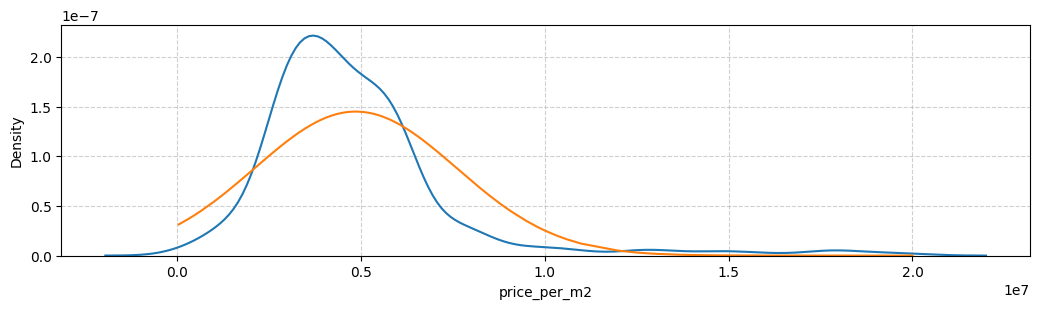

In [7]:
pdf = stats.norm.pdf(df_filtered['price_per_m2'].sort_values(), mean, std)

_, ax = plt.subplots(1,1, figsize=(12.5,3))
sns.kdeplot(ax=ax, data=df_filtered['price_per_m2'].sort_values())
ax.plot(df_filtered['price_per_m2'].sort_values(), pdf)

plt.xlabel("price_per_m2")
plt.ylabel("Density")
plt.grid(True, alpha=0.6, linestyle="--")
plt.show()

In [8]:
# np.save('files/npy/locations_cmh.npy', df_filtered['Location'].unique())

In [9]:
import folium
import glob
import json


site_map = folium.Map(location=[-6.9301133,107.6208473],
                      tiles="Cartodb voyager",
                      zoom_start=11.5,
                      zoom_control=False
                      )
                    #   attr=xyz.Stadia.StamenTerrain.html_attribution,
fol = folium.Figure(width=700, height=300)
site_map.add_to(fol)

location_map = dict()
files = glob.glob('files/json/*cimahi--*')
for f in files:
    with open(f) as loc:
        arr = json.load(loc)
        lat, lng = arr[0]['geometry']['location'].values()
        loc_name = f.replace('.json','').replace('files/json/','')
        location_map[loc_name] = (lat, lng)
        folium.Circle(
            location=(lat, lng),
            radius=1000,
            color="black",
            fill_opacity=0.5,
            opacity=0,
            fill_color="red",
            tooltip=loc_name,
        ).add_to(site_map)

fol

In [10]:
def format_loc(loc: str):
    area = loc.split(',')[-1].strip()
    subarea = ''.join(loc.split(',')[:-1]).strip()
    return f"{area}--{subarea}".replace(" ","_").lower()


traindata = df_filtered[['price_per_m2','Location']].reset_index(drop=True)
traindata['Location'] = traindata['Location'].apply(format_loc)
traindata.assign(x=[0.0]*len(traindata), y=[0.0]*len(traindata))
traindata = traindata.reindex(columns=['Location', 'lat' ,'lng', 'price_per_m2'])
traindata['lat'] = traindata['Location'].apply(lambda l: location_map[l][0])
traindata['lng'] = traindata['Location'].apply(lambda l: location_map[l][1])
traindata.describe()

,lat,lng,price_per_m2
count,1197.000000,1197.000000,1.197000e+03
mean,-6.870154,107.550916,4.865270e+06
std,0.013185,0.008596,2.748707e+06
min,-6.902922,107.529805,5.714286e+04
25%,-6.872979,107.541227,3.100000e+06
50%,-6.863315,107.556433,4.063158e+06
75%,-6.863315,107.556433,5.956284e+06
max,-6.863315,107.556433,2.000000e+07


In [11]:
traindata_bounds = traindata[['Location','price_per_m2']]
size = traindata_bounds.groupby(by='Location', as_index=False).size()
traindata_bounds = traindata_bounds.groupby('Location').quantile(q=0.5).reset_index()
traindata_bounds['count'] = size['size']
traindata_bounds = traindata_bounds[traindata_bounds['count'] >= 10].reset_index(drop=True)
traindata_bounds

,Location,price_per_m2,count
0,cimahi--cimahi_selatan,4000000.0,124
1,cimahi--cimahi_tengah,6000000.0,208
2,cimahi--cimahi_utara,4000000.0,833
3,cimahi--leuwi_gajah,3450000.0,32


In [12]:
def get_bounds(loc_str: str):
    with open(f'files/json/{loc_str}.json', 'r') as f:
        arr = json.load(f)
        count_bounds = 0
        min_bounds_id = 0
        min_bounds = float('inf')
        for i, loc in enumerate(arr):
            if ('bounds' in loc['geometry']):
                count_bounds += 1
                ne, sw = loc['geometry']['bounds'].values()
                h, w = np.array(list(ne.values())) - np.array(list(sw.values()))
                if h * w < min_bounds:
                    min_bounds = h * w
                    min_bounds_id = i
        if count_bounds == 0:
            LatPointExtra = LngPointExtra = 0.00406
            lat, lng = arr[0]['geometry']['location'].values()
            return lat + LatPointExtra, lng + LngPointExtra, lat - LatPointExtra, lng - LngPointExtra
        else:
            ne, sw = arr[min_bounds_id]['geometry']['bounds'].values()
            return ne['lat'], ne['lng'], sw['lat'], sw['lng']

bounds = pd.DataFrame(traindata_bounds['Location'].apply(get_bounds).to_list(), columns=['ne_lat', 'ne_lng', 'sw_lat', 'sw_lng'])
traindata_bounds = pd.concat([traindata_bounds, bounds], axis=1)
traindata_bounds

,Location,price_per_m2,count,ne_lat,ne_lng,sw_lat,sw_lng
0,cimahi--cimahi_selatan,4000000.0,124,-6.880584,107.569034,-6.932934,107.510205
1,cimahi--cimahi_tengah,6000000.0,208,-6.866340,107.560645,-6.906175,107.518746
2,cimahi--cimahi_utara,4000000.0,833,-6.831747,107.576309,-6.890739,107.523077
3,cimahi--leuwi_gajah,3450000.0,32,-6.893517,107.536581,-6.921208,107.516899


In [13]:
# traindata_bounds.drop(['count'], axis=1).to_csv('files/csv/traindata_bounds.csv', mode='a', index=False, header=False)